> Try to divide train and test(GNAR fivenet)

# import

In [1]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt
import pandas as pd

import time

from scipy.interpolate import interp1d

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# R

In [3]:
%load_ext rpy2.ipython

In [154]:
%%R
library(GNAR)
library(igraph)

# Data

In [5]:
%%R
summary(fiveNet)

GNARnet with 5 nodes and 10 edges
 of equal length  1

In [6]:
%%R
edges <- as.matrix(fiveNet)
data("fiveNode")

In [7]:
%R -o fiveVTS
%R -o edges

- node: 5
- time 200

In [8]:
edges_tensor = torch.tensor(edges)

In [9]:
nonzero_indices = edges_tensor.nonzero()

In [10]:
fiveNet_edge = np.array(nonzero_indices).T

In [11]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [12]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [13]:
fiveVTS.shape

(200, 5)

In [14]:
fiveVTS_train = fiveVTS[:int(len(fiveVTS)*0.8)]
fiveVTS_test = fiveVTS[int(len(fiveVTS)*0.8):]

In [15]:
fiveVTS_train.shape, fiveVTS_test.shape

((160, 5), (40, 5))

# Randomly Missing Values

In [160]:
np.random.seed(1)
seed_number1 = np.random.choice(160,80,replace=False)

In [161]:
np.random.seed(3)
seed_number2 = np.random.choice(160,80,replace=False)

In [162]:
np.random.seed(5)
seed_number3 = np.random.choice(160,80,replace=False)

In [163]:
np.random.seed(7)
seed_number4 = np.random.choice(160,80,replace=False)

In [164]:
np.random.seed(9)
seed_number5 = np.random.choice(160,80,replace=False)

In [165]:
fiveVTS_train[seed_number1,0] = float('nan')

In [166]:
fiveVTS_train[seed_number2,1] = float('nan')

In [167]:
fiveVTS_train[seed_number3,2] = float('nan')

In [168]:
fiveVTS_train[seed_number4,3] = float('nan')

In [169]:
fiveVTS_train[seed_number5,4] = float('nan')

# 1. Missing Value - Mean

In [26]:
fiveVTS_train_mean = fiveVTS_train.copy()

In [27]:
fiveVTS_train_mean[seed_number1,0] = np.nanmean(fiveVTS_train_mean[:,0])

In [28]:
fiveVTS_train_mean[seed_number2,1] = np.nanmean(fiveVTS_train_mean[:,1])

In [29]:
fiveVTS_train_mean[seed_number3,2] = np.nanmean(fiveVTS_train_mean[:,2])

In [30]:
fiveVTS_train_mean[seed_number4,3] = np.nanmean(fiveVTS_train_mean[:,3])

In [31]:
fiveVTS_train_mean[seed_number5,4] = np.nanmean(fiveVTS_train_mean[:,4])

## 1) ST-GCN

In [32]:
mean_f_fiveVTS_train = torch.tensor(fiveVTS_train_mean).reshape(160,5,1).float()

In [33]:
mean_X_fiveVTS = mean_f_fiveVTS_train[:159,:,:]
mean_y_fiveVTS = mean_f_fiveVTS_train[1:,:,:]

In [34]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_fiveVTS,mean_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


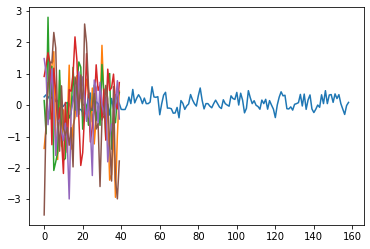

In [174]:
plt.plot(mean_fhat_fiveVTS[:,0])
plt.plot(fiveVTS_test)

### ST-GCN만 한 상태에서 true값과 비교

In [176]:
mean_X_fore_fiveVTS = torch.tensor(fiveVTS_train_mean[120:,:]).reshape(40,5,1).float()

In [177]:
mean_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_fore_fiveVTS]).detach().numpy()

In [178]:
(mean_fhat_fiveVTS.reshape(40,5)[1] -  fiveVTS_test[1])

array([ 0.72109859,  0.94232791, -1.24866388, -0.98387925,  0.35362056])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba3078a7c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba3078ad90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba3078a4f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba3079a370>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba3079a640>,
 'means': []}

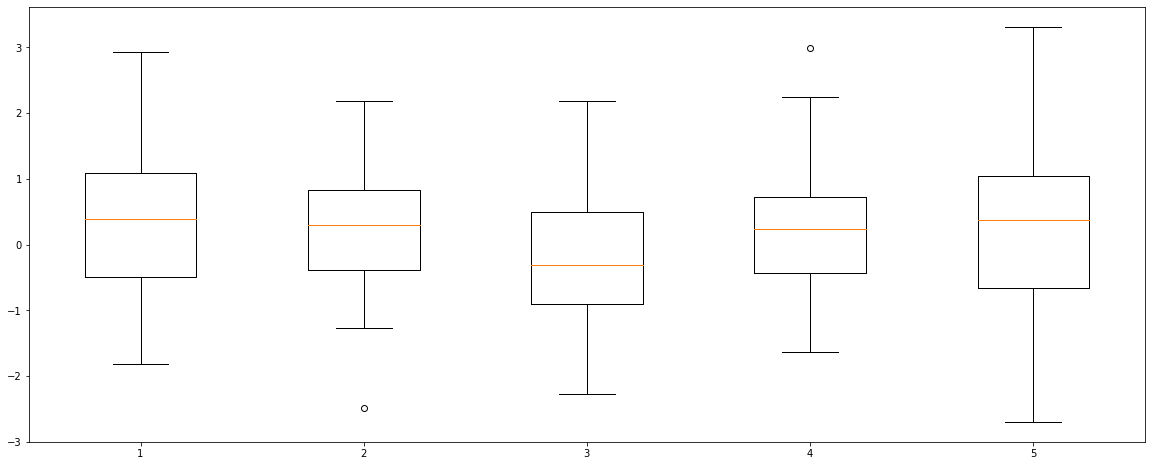

In [48]:
plt.figure(figsize=(20, 8))
plt.boxplot((mean_fhat_fiveVTS.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba306d03d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba306d0970>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba306d0100>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba306d0f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba306de220>],
 'means': []}

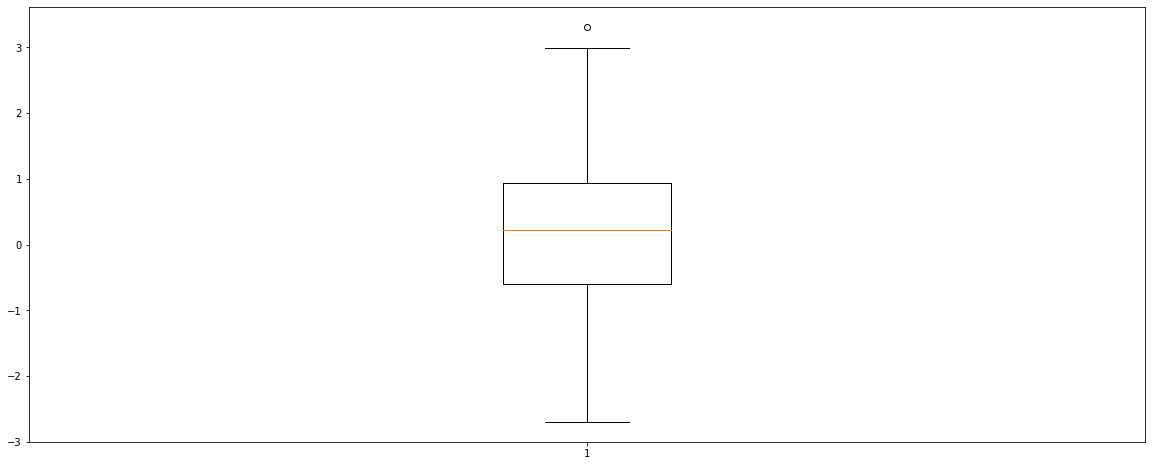

In [49]:
plt.figure(figsize=(20, 8))
plt.boxplot(((mean_fhat_fiveVTS.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

---

## 2) Temporal $\to$ ST-GCN

In [50]:
mean_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_fiveVTS]).detach().numpy()

In [51]:
w=np.zeros((N,159,159))

In [52]:
for k in range(N):
    for i in range(159):
        for j in range(159):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [53]:
d = np.array([w[i].sum(axis=1) for i in range(N)])
D= np.array([np.diag(d[i]) for i in range(N)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(N)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(N)])    
fhatbar = np.hstack([Psi[i] @ mean_fhat_fiveVTS[:,i] for i in range(N)])
_fhatbar = fhatbar.reshape(N,159)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(N)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(N)])    
fhatbarhat_mean_temporal = fhatbarhat.reshape(159,-1)

### ST-GCN만 한 상태에서 true값과 비교

In [54]:
mean_temporal = torch.tensor(fhatbarhat_mean_temporal).reshape(159,5,1).float()

In [55]:
mean_X_temporal = mean_temporal[:158,:,:]
mean_y_temporal = mean_temporal[1:,:,:]

In [56]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_temporal,mean_y_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


In [57]:
mean_X_temporal_fore = mean_temporal[119:,:,:]

In [59]:
mean_fhat_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_temporal_fore]).detach().numpy()

In [60]:
(mean_fhat_temporal.reshape(40,5)[1] -  fiveVTS_test[1])

array([ 0.76215137,  0.92118497, -1.27401298, -1.01342119,  0.3446341 ])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba3066f040>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba3066f5e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba3065fe50>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba3066fb80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba3066fe50>,
 'means': []}

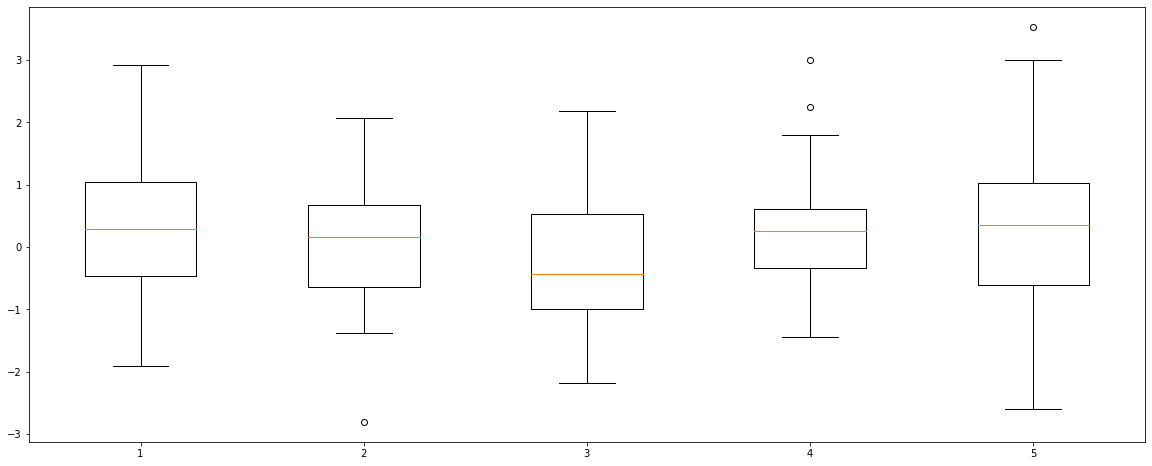

In [61]:
plt.figure(figsize=(20, 8))
plt.boxplot((mean_fhat_temporal.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba30596eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba305a5490>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba30596cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba305a5a30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba305a5d00>],
 'means': []}

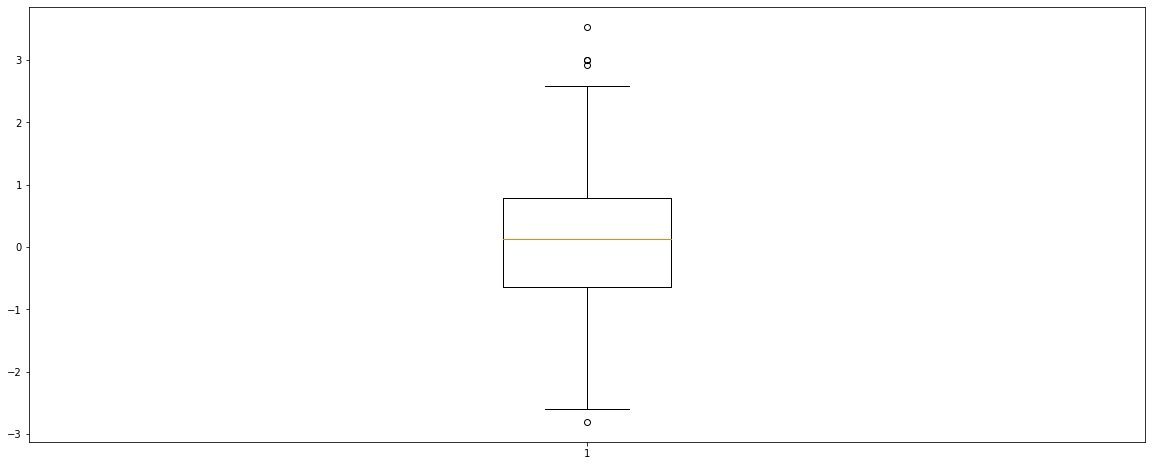

In [62]:
plt.figure(figsize=(20, 8))
plt.boxplot(((mean_fhat_temporal.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## 3) Spatio $\to$ ST-GCN

In [63]:
w=np.zeros((N,N))

In [64]:
for i in range(N):
    for j in range(N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [65]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ mean_fhat_fiveVTS.reshape(N,159)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio = fhatbarhat.reshape(159,-1)

### ST-GCN만 한 상태에서 true값과 비교

In [66]:
mean_spatio = torch.tensor(fhatbarhat_mean_spatio).reshape(159,5,1).float()

In [67]:
mean_X_spatio = mean_spatio[:158,:,:]
mean_y_spatio = mean_spatio[1:,:,:]

In [68]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_spatio,mean_y_spatio)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


In [69]:
mean_X_spatio_fore = mean_spatio[119:,:,:]

In [70]:
mean_fhat_spatio = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_spatio_fore]).detach().numpy()

In [71]:
(mean_fhat_spatio.reshape(40,5)[1] -  fiveVTS_test[1])

array([ 0.61463491,  0.76944418, -1.41762615, -1.1639043 ,  0.24719958])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba3052a940>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba3052aee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba3052a670>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba302784c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba30278790>,
 'means': []}

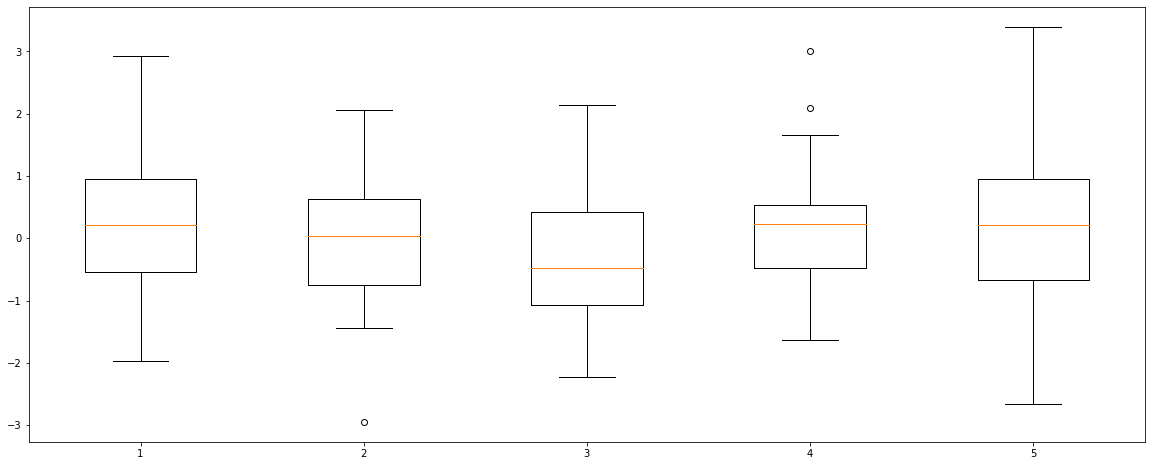

In [72]:
plt.figure(figsize=(20, 8))
plt.boxplot((mean_fhat_spatio.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba3021ee50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba3022e430>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba3020f9d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba3022ea00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba3022ecd0>],
 'means': []}

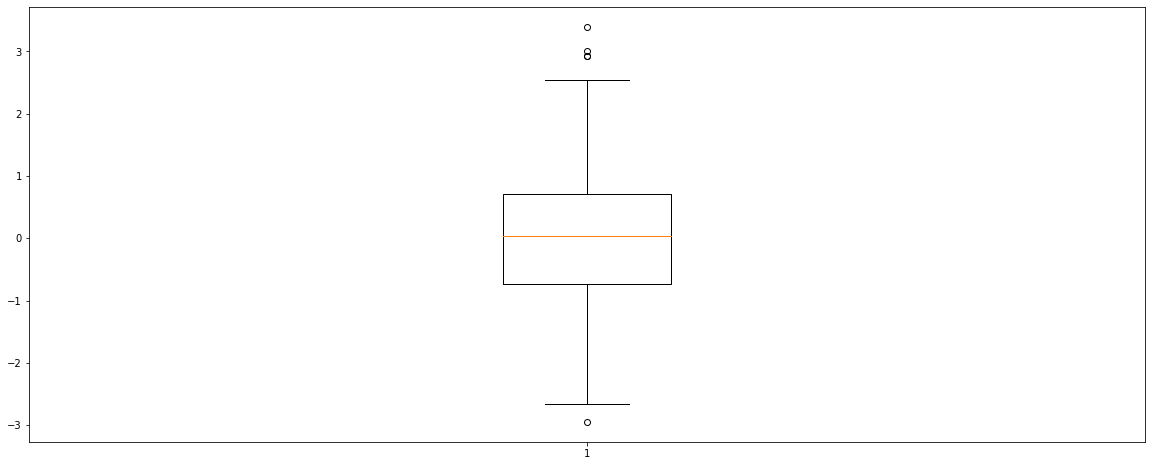

In [73]:
plt.figure(figsize=(20, 8))
plt.boxplot(((mean_fhat_spatio.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## 4) Spatio-Temporal $\to$ ST-GCN

In [74]:
w=np.zeros((159*N,159*N))

In [75]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [76]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ mean_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio_temporal = fhatbarhat.reshape(159,N,1)

### ST-GCN만 한 상태에서 true값과 비교

In [77]:
mean_spatio_temporal = torch.tensor(fhatbarhat_mean_spatio_temporal).reshape(159,5,1).float()

In [78]:
mean_X_spatio_temporal = mean_spatio_temporal[:158,:,:]
mean_y_spatio_temporal = mean_spatio_temporal[1:,:,:]

In [79]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_spatio_temporal,mean_y_spatio_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


In [80]:
mean_X_spatio_temporal_fore = mean_spatio_temporal[119:,:,:]

In [81]:
mean_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_spatio_temporal_fore]).detach().numpy()

In [82]:
(mean_fhat_spatio_temporal.reshape(40,5)[1] -  fiveVTS_test[1])

array([ 0.71870126,  0.94757683, -1.25974104, -0.9921751 ,  0.36159626])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba3013e070>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba3013e610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba301c4160>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba3013ebe0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba3013eeb0>,
 'means': []}

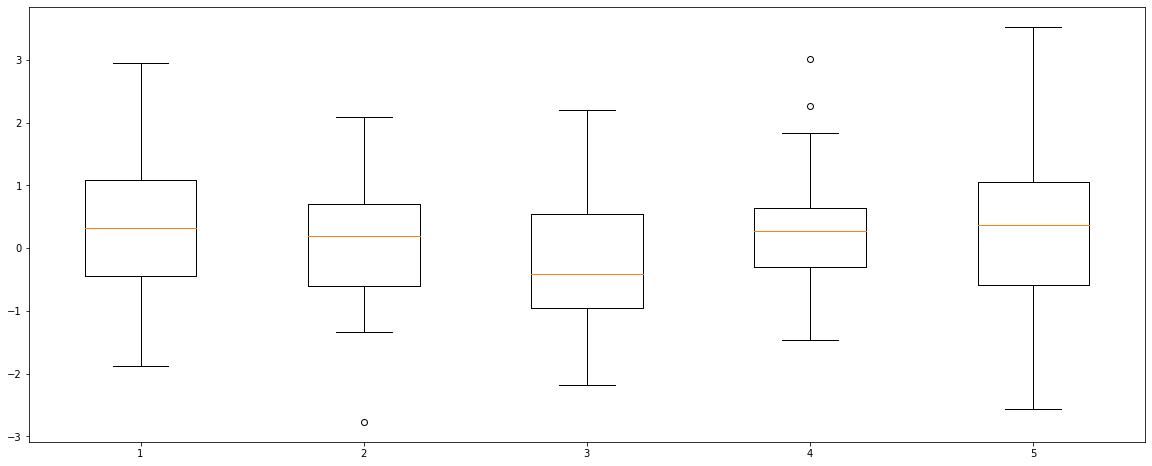

In [83]:
plt.figure(figsize=(20, 8))
plt.boxplot((mean_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba300f08b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba300f0e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba300e3400>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba3007c430>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba3007c700>],
 'means': []}

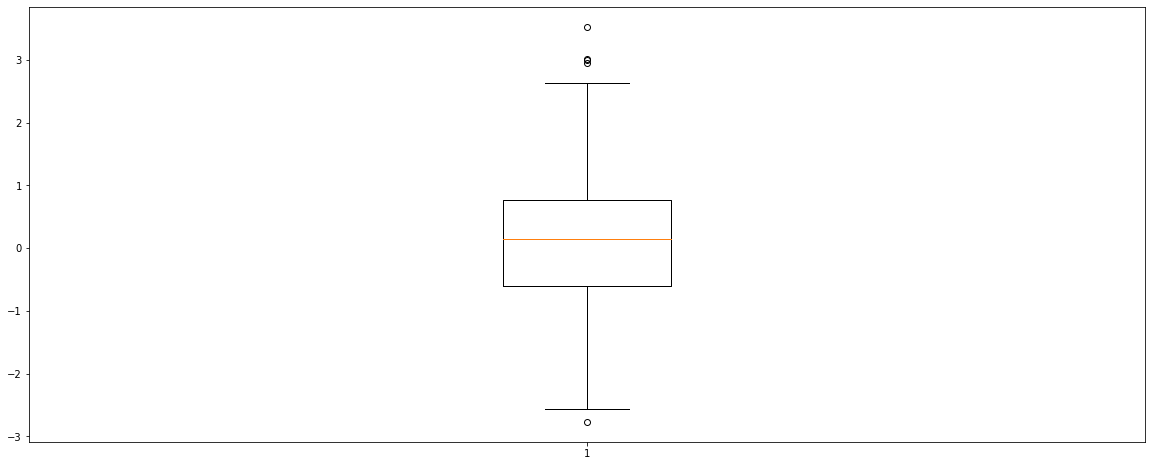

In [84]:
plt.figure(figsize=(20, 8))
plt.boxplot(((mean_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

# 2. Missing Value - Linear Interpolation

In [85]:
_df = pd.DataFrame(fiveVTS_train)
_df.interpolate(method='linear', inplace=True)
_df = _df.fillna(0)

In [86]:
linear_fiveVTS_train = np.array(_df).reshape(160,5)

## 1) ST-GCN

In [87]:
linear_f_fiveVTS_train = torch.tensor(linear_fiveVTS_train).reshape(160,5,1).float()

In [88]:
linear_X_fiveVTS = linear_f_fiveVTS_train[:159,:,:]
linear_y_fiveVTS = linear_f_fiveVTS_train[1:,:,:]

In [89]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_fiveVTS,linear_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


### ST-GCN만 한 상태에서 true값과 비교

In [90]:
linear_X_fore_fiveVTS = linear_f_fiveVTS_train[120:,:,:]

In [91]:
linear_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_fore_fiveVTS]).detach().numpy()

In [92]:
(linear_fhat_fiveVTS.reshape(40,5)[1] -  fiveVTS_test[1])

array([ 0.5884296 ,  0.93915328, -0.86353006, -0.32309763,  0.81814396])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba283d1100>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba283d16d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba283c0df0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba283d1c70>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba283d1f40>,
 'means': []}

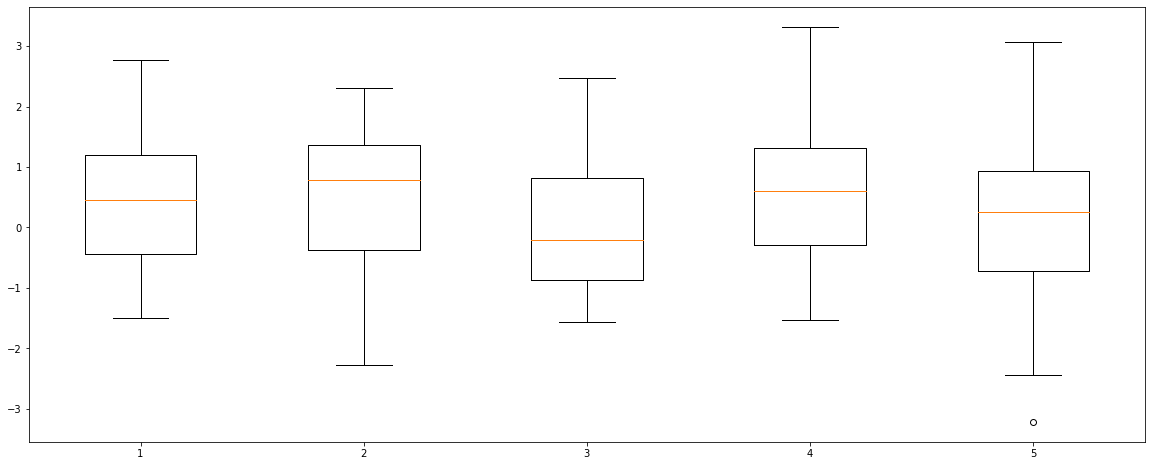

In [93]:
plt.figure(figsize=(20, 8))
plt.boxplot((linear_fhat_fiveVTS.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba28304760>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba28304d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba282f82b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba283112e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba283115b0>],
 'means': []}

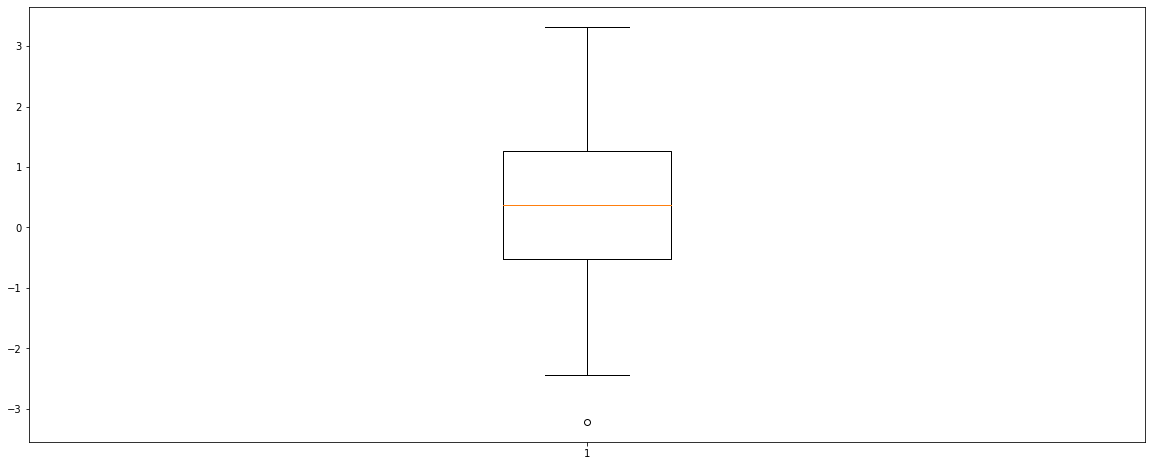

In [94]:
plt.figure(figsize=(20, 8))
plt.boxplot(((linear_fhat_fiveVTS.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## 2) Temporal $\to$ ST-GCN

In [95]:
linear_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_fiveVTS]).detach().numpy()

In [96]:
w=np.zeros((N,159,159))

In [97]:
for k in range(N):
    for i in range(159):
        for j in range(159):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [98]:
d = np.array([w[i].sum(axis=1) for i in range(N)])
D= np.array([np.diag(d[i]) for i in range(N)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(N)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(N)])    
fhatbar = np.hstack([Psi[i] @ linear_fhat_fiveVTS[:,i] for i in range(N)])
_fhatbar = fhatbar.reshape(N,159)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(N)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(N)])    
fhatbarhat_linear_temporal = fhatbarhat.reshape(159,-1)

### ST-GCN만 한 상태에서 true값과 비교

In [99]:
linear_temporal = torch.tensor(fhatbarhat_linear_temporal).reshape(159,5,1).float()

In [100]:
linear_X_temporal = linear_temporal[:158,:,:]
linear_y_temporal = linear_temporal[1:,:,:]

In [101]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_temporal,linear_y_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


In [102]:
linear_X_temporal_fore = linear_temporal[119:,:,:]

In [103]:
linear_fhat_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_temporal_fore]).detach().numpy()

In [104]:
(linear_fhat_temporal.reshape(40,5)[1] -  fiveVTS_test[1])

array([ 0.81009904,  1.06553185, -1.2376281 , -0.94720779,  0.39560674])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba282a0dc0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba282303d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba282a0af0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba28230970>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba28230c40>,
 'means': []}

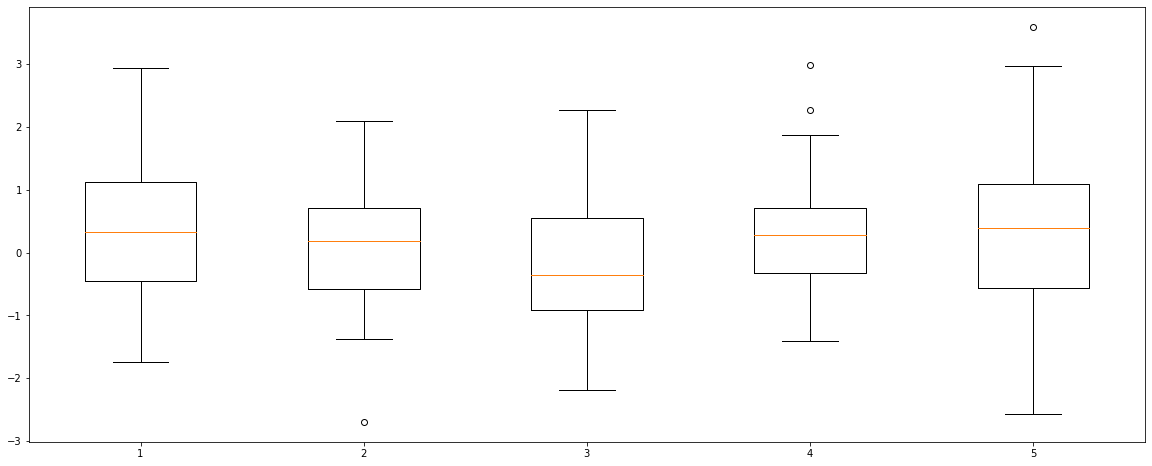

In [105]:
plt.figure(figsize=(20, 8))
plt.boxplot((linear_fhat_temporal.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba306a1df0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba301843d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba306a1af0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba30184970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba30184c40>],
 'means': []}

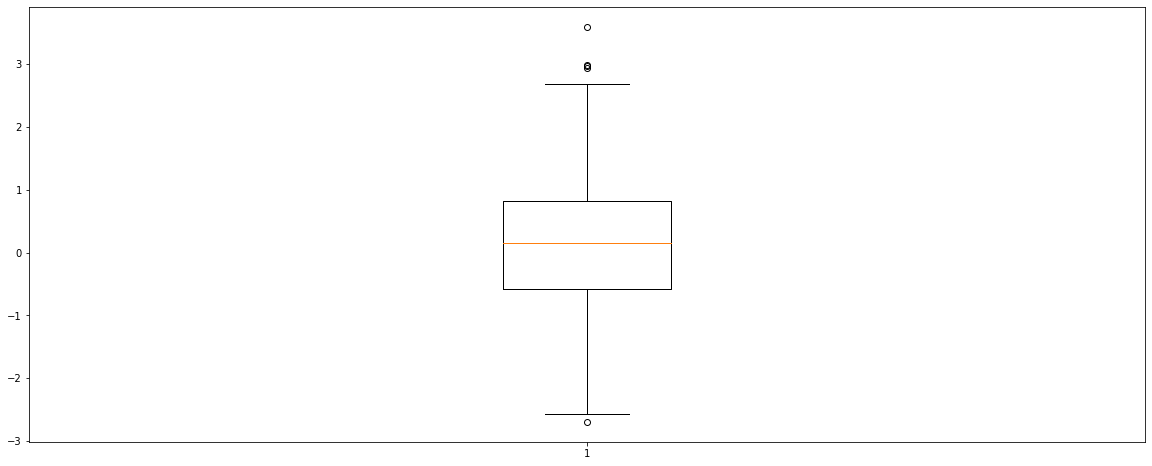

In [106]:
plt.figure(figsize=(20, 8))
plt.boxplot(((linear_fhat_temporal.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## 3) Spatio $\to$ ST-GCN

In [107]:
w=np.zeros((N,N))

In [108]:
for i in range(N):
    for j in range(N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [109]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ linear_fhat_fiveVTS.reshape(N,159)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linear_spatio = fhatbarhat.reshape(159,-1)

### ST-GCN만 한 상태에서 true값과 비교

In [110]:
linear_spatio = torch.tensor(fhatbarhat_linear_spatio).reshape(159,5,1).float()

In [111]:
linear_X_spatio = linear_spatio[:158,:,:]
linear_y_spatio = linear_spatio[1:,:,:]

In [112]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_spatio,linear_y_spatio)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


In [113]:
linear_X_spatio_fore = linear_spatio[119:,:,:]

In [114]:
linear_fhat_spatio = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_spatio_fore]).detach().numpy()

In [115]:
(linear_fhat_spatio.reshape(40,5)[1] -  fiveVTS_test[1])

array([ 0.36965964,  0.57035639, -2.31763076, -1.40237264,  0.00630998])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba281aba60>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba281ba040>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba281ab880>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba281ba5e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba281ba8b0>,
 'means': []}

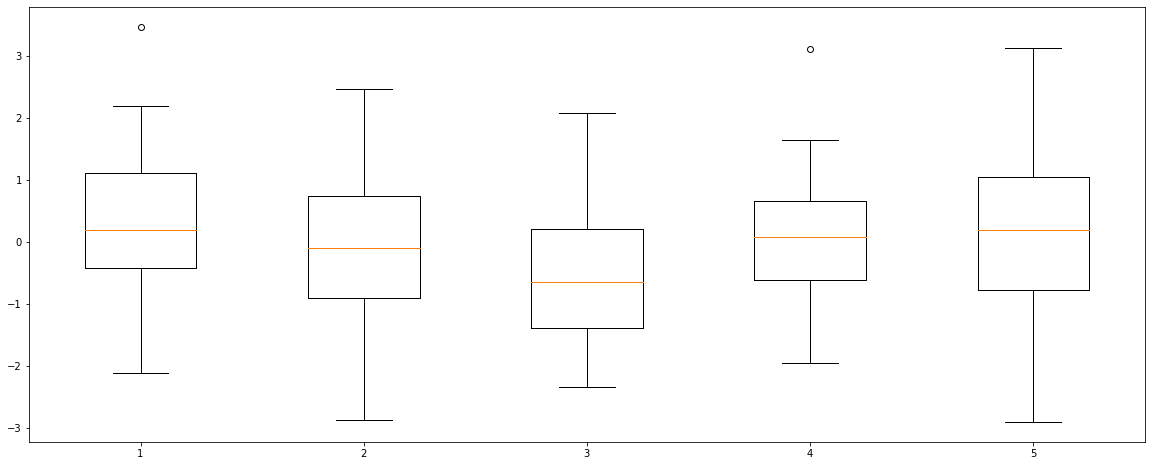

In [116]:
plt.figure(figsize=(20, 8))
plt.boxplot((linear_fhat_spatio.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba281657c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba28165d60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba28158310>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba280f2340>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba280f2610>],
 'means': []}

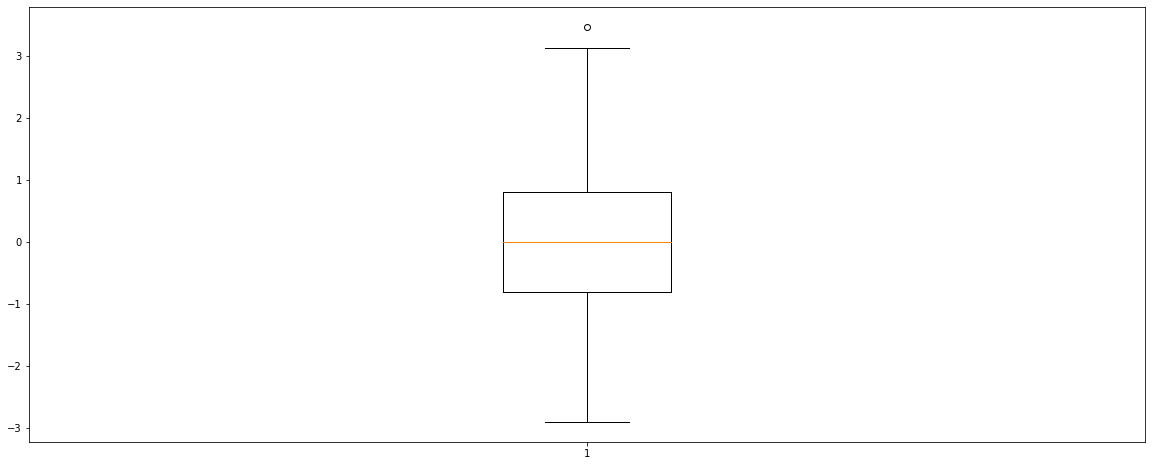

In [117]:
plt.figure(figsize=(20, 8))
plt.boxplot(((linear_fhat_spatio.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## 4) Spatio-Temporal $\to$ ST-GCN

In [137]:
w=np.zeros((159*N,159*N))

In [138]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [139]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ linear_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linear_spatio_temporal = fhatbarhat.reshape(159,N,1)

### ST-GCN만 한 상태에서 true값과 비교

In [179]:
linear_spatio_temporal = torch.tensor(fhatbarhat_linear_spatio_temporal).reshape(159,5,1).float()

In [180]:
linear_X_spatio_temporal = linear_spatio_temporal[:158,:,:]
linear_y_spatio_temporal = linear_spatio_temporal[1:,:,:]

In [181]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_spatio_temporal,linear_y_spatio_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


In [182]:
linear_X_spatio_temporal_fore = linear_spatio_temporal[119:,:,:]

In [183]:
linear_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_spatio_temporal_fore]).detach().numpy()

In [187]:
fiveVTS_test.shape

(40, 5)

In [147]:
(linear_fhat_spatio_temporal.reshape(40,5)[1] -  fiveVTS_test[1])

array([ 0.70990738,  0.93671374, -1.24731856, -0.99082219,  0.35342387])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba13089a30>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba1309b040>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba13089760>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba1309b5e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba1309b8b0>,
 'means': []}

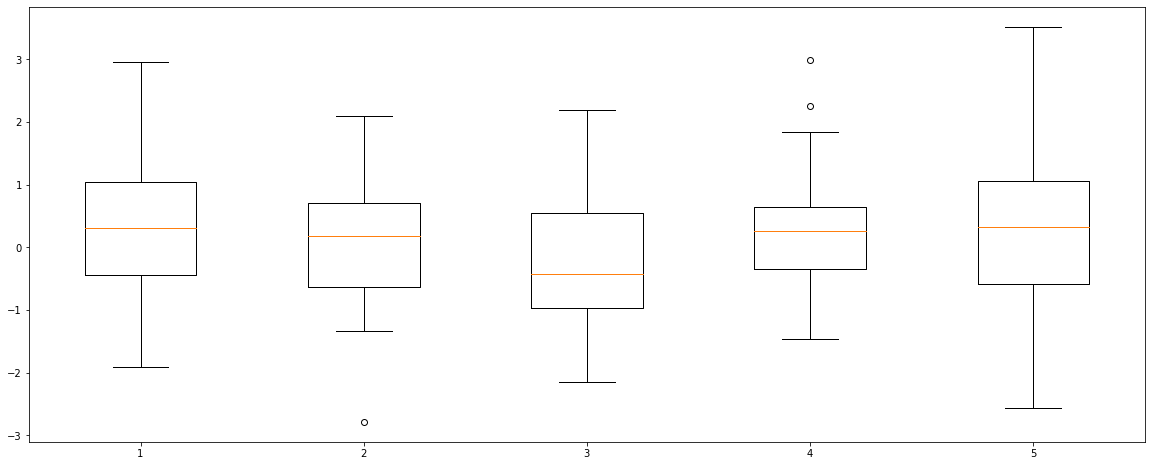

In [151]:
plt.figure(figsize=(20, 8))
plt.boxplot((linear_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba130ab7c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba130abd60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba130ab610>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba130b8340>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba130b8610>],
 'means': []}

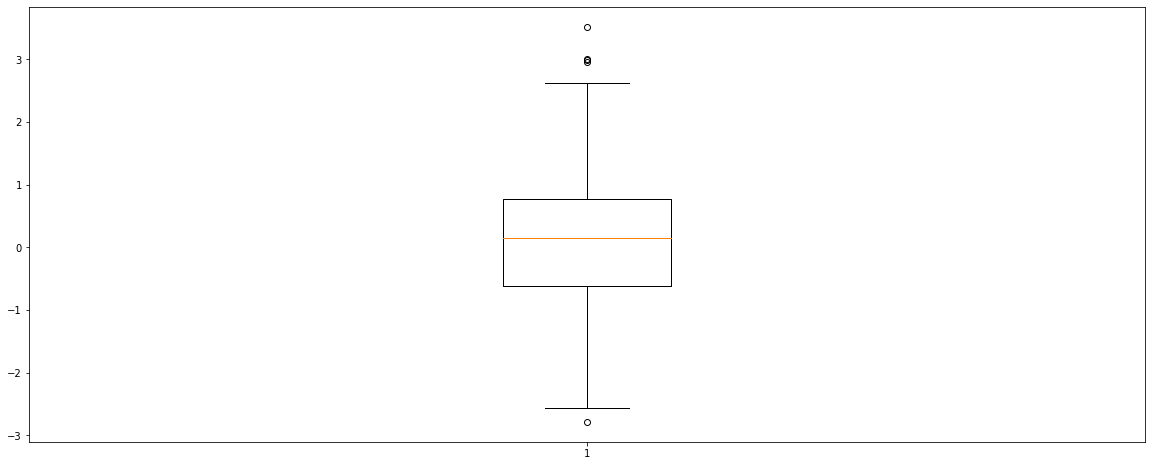

In [150]:
plt.figure(figsize=(20, 8))
plt.boxplot(((linear_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## GNAR

**mean**

In [129]:
%R -i fiveVTS_train_mean

In [130]:
%%R
meanprediction <- predict(GNARfit(vts = fiveVTS_train_mean[1:160,], net = fiveNet, alphaOrder = 2, betaOrder = c(1, 1)),n.ahead=40)

In [131]:
%R -o meanprediction

In [132]:
sum((meanprediction.reshape(40,5)[1] -  fiveVTS_test[1])**2)

3.8828590908470577

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba1030bee0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba1031f4c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba1030bd30>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba1031fa60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba1031fd30>,
 'means': []}

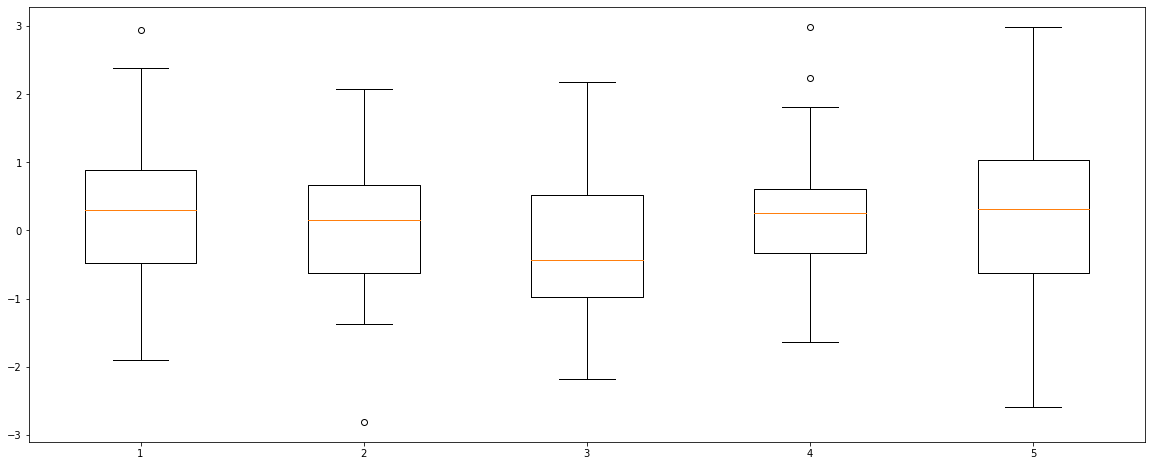

In [152]:
plt.figure(figsize=(20, 8))
plt.boxplot((meanprediction.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba102544c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba10254a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba10245040>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba10260070>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba10260340>],
 'means': []}

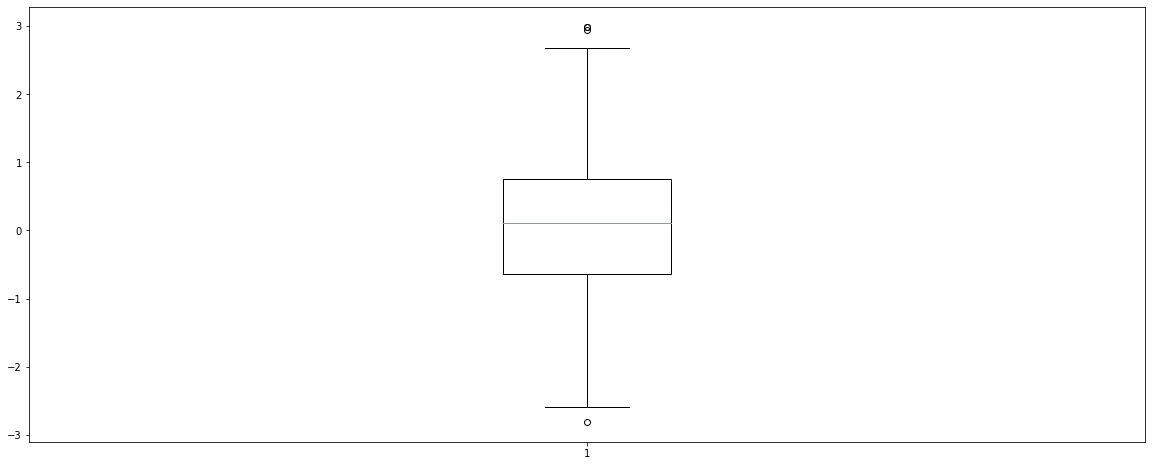

In [153]:
plt.figure(figsize=(20, 8))
plt.boxplot(((meanprediction.reshape(40,5) -  fiveVTS_test)).reshape(200,1))